# Motivation

&#9708; <span style="color:green"><span style="font-family:Comic Sans MS">**Gradient Ascent Take-Home Assignment-1**</span></span>

&#9708; <span style="color:green"> **Option-I : Business Names**</span>


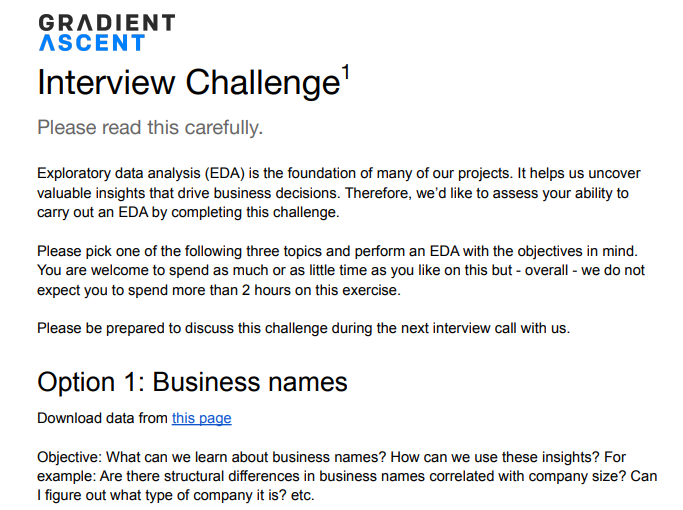

# Train-Of-Thought

- [x]    Load Pre-Processed Data
    

- [x]    Binary-Classification Model  


- [x]    Key Points to Highlight

            
            * Use missing industry records as target=1 i.e. shell companies
            * Year-Founded has outliers both on the low and high end
            * We can see an increasing trend since 1945-->2020
            * I choose not to handle outliers in year-founded as I will be using XGBoost which is immune to feature outliers
            * Companies which are present in more than 1 locality are less likely to be shell
            * Employee count delta is a strong indicator for shell companies

# Load Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
import warnings
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler

In [3]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)

# Utilities 

# Load Data

In [138]:
data = pd.read_feather(
    "C:\\Users\\Zeus\\Downloads\\Road_To_Glory\\2022\\Gradient Ascent\\archive\\business_name_processed.feather"
)

In [6]:
print(data.shape)
display(data.head())

(7173426, 10)


,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,ibm,ibm.com,1911,information technology and services,10001+,"new york, new york, united states",united states,ibm,274047,716906
1,tata consultancy services,tcs.com,1968,information technology and services,10001+,"bombay, maharashtra, india",india,tata-consultancy-services,190771,341369
2,accenture,accenture.com,1989,information technology and services,10001+,"dublin, dublin, ireland",ireland,accenture,190689,455768
3,us army,goarmy.com,1800,military,10001+,"alexandria, virginia, united states",united states,us-army,162163,445958
4,ey,ey.com,1989,accounting,10001+,"london, greater london, united kingdom",united kingdom,ernstandyoung,158363,428960


# Exploratory Data Analysis

## Uni-Variate Analysis

### Industry a.k.a Target

In [144]:
data.industry.value_counts(normalize=True)[:20]*100

information technology and services    6.315588
marketing and advertising              4.714093
missing                                4.042741
construction                           3.595507
management consulting                  2.712177
real estate                            2.697261
computer software                      2.666355
internet                               2.400638
financial services                     2.382125
health, wellness and fitness           2.030703
hospital & health care                 1.959928
education management                   1.906272
retail                                 1.687966
design                                 1.674974
automotive                             1.451789
non-profit organization management     1.381139
hospitality                            1.366711
food & beverages                       1.289997
accounting                             1.243520
entertainment                          1.242475
Name: industry, dtype: float64

    - Take the ~4% missing records and mark them as label 1
    - drop the industry columns from further analysis

In [80]:
data['target'] = data.industry.swifter.apply(lambda x: 1
                                             if str(x) == 'missing' else 0)

In [96]:
data.drop(columns=['industry'],inplace=True)

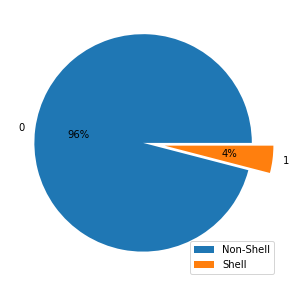

In [95]:
f, ax = plt.subplots(figsize=(5, 5))
sns.despine(f)
plt.pie(data.target.value_counts(normalize=True).values * 100,
        labels=[0, 1],
        explode=[0, 0.2],
        autopct='%.0f%%')
plt.legend(['Non-Shell', 'Shell'], loc='lower right')
plt.show()
del f, ax

In [97]:
print(data.shape)
display(data.head())

(7173426, 10)


,name,domain,year founded,size range,locality,country,linkedin url,current employee estimate,total employee estimate,target
0,ibm,ibm.com,1911,10001+,"new york, new york, united states",united states,ibm,274047,716906,0
1,tata consultancy services,tcs.com,1968,10001+,"bombay, maharashtra, india",india,tata-consultancy-services,190771,341369,0
2,accenture,accenture.com,1989,10001+,"dublin, dublin, ireland",ireland,accenture,190689,455768,0
3,us army,goarmy.com,1800,10001+,"alexandria, virginia, united states",united states,us-army,162163,445958,0
4,ey,ey.com,1989,10001+,"london, greater london, united kingdom",united kingdom,ernstandyoung,158363,428960,0


### Year Founded 

In [104]:
data[data['year founded'] != -999]['year founded'].value_counts(
    normalize=True).sort_index()[:10]

1451    2.803912e-07
1670    2.803912e-07
1775    8.411735e-07
1789    5.607824e-07
1792    2.803912e-07
1799    2.803912e-07
1800    2.803912e-07
1801    1.373917e-05
1802    1.261760e-05
1803    1.373917e-05
Name: year founded, dtype: float64

In [106]:
data[data['year founded'] != -999]['year founded'].value_counts(
    normalize=True).sort_index()[-10:]

2018    7.517848e-03
2019    4.766650e-06
2020    1.962738e-06
2021    2.803912e-07
2022    8.411735e-07
2023    2.803912e-07
2025    1.121565e-06
2027    2.803912e-07
2029    2.803912e-07
2103    2.803912e-07
Name: year founded, dtype: float64

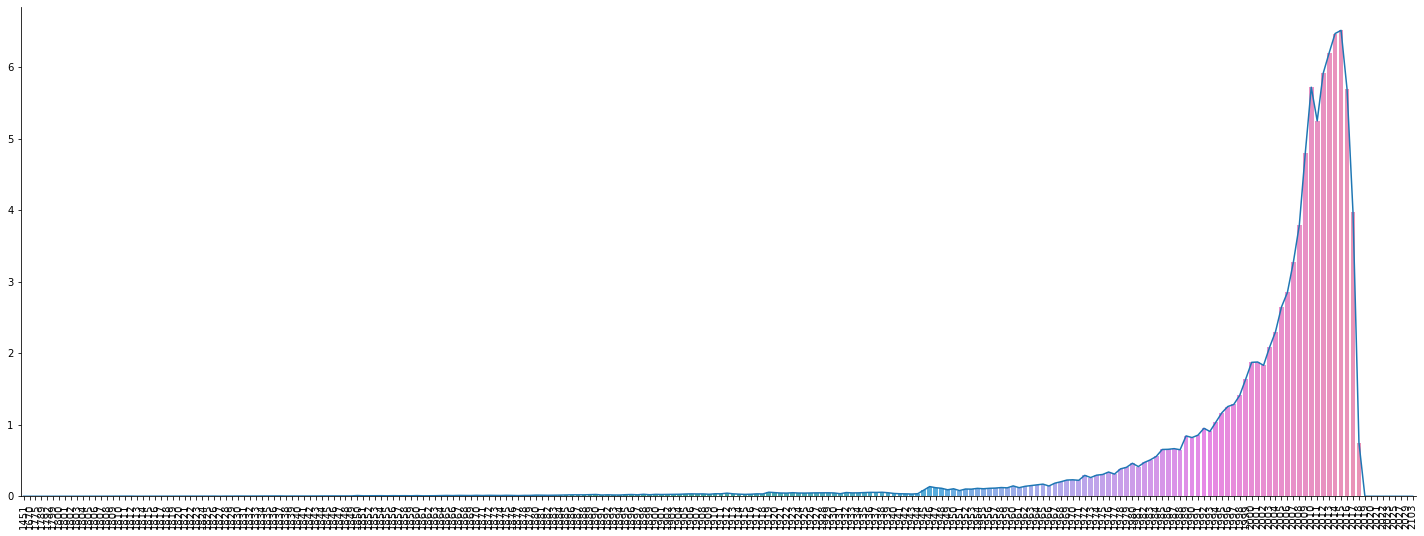

In [111]:
f, ax = plt.subplots(figsize=(25, 9))
sns.despine(f)
plt.plot(data[data['year founded'] != -999]['year founded'].value_counts(
    normalize=True).sort_index().values * 100)
sns.barplot(x=data[data['year founded'] != -999]['year founded'].value_counts(
    normalize=True).sort_index().index,
            y=data[data['year founded'] != -999]['year founded'].value_counts(
                normalize=True).sort_index().values * 100)
plt.xticks(rotation=90)
del f, ax

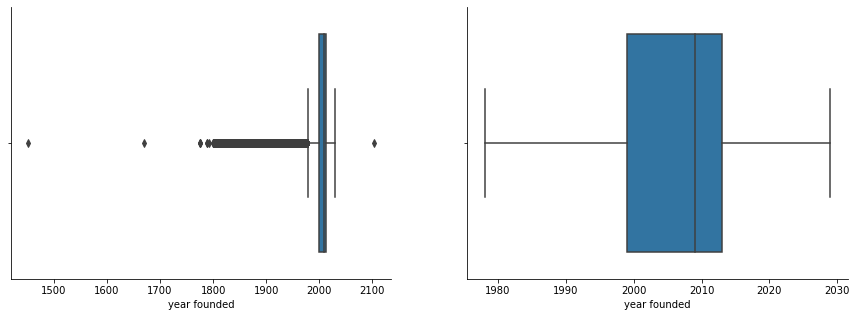

In [113]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
sns.despine(fig)
sns.boxplot(data[data['year founded'] != -999]['year founded'],
            showfliers=True,
            ax=axarr[0])
sns.boxplot(data[data['year founded'] != -999]['year founded'],
            showfliers=False,
            ax=axarr[1])
plt.close(2)
plt.close(3)
del fig, axarr

    - We can see the increase in companies being founded from year 1945
    - We can also observe some outliers on both extremes
    - Some founded years are too ahead in future

### Name

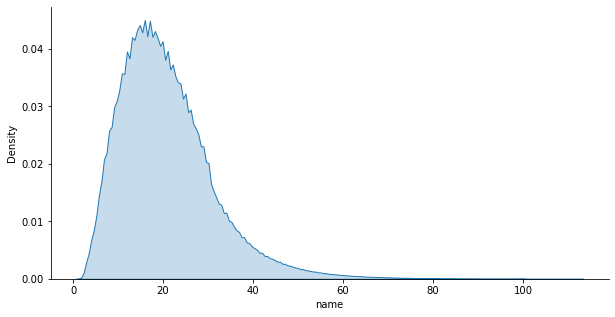

In [114]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(data['name'].apply(len), shade=True)
plt.show()
del f,ax

### Domain

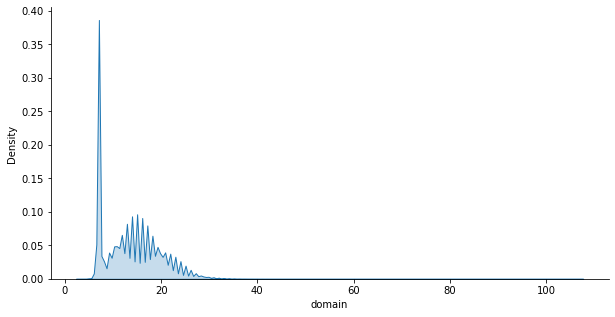

In [115]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(data['domain'].apply(len), shade=True)
plt.show()
del f,ax

### Country

In [130]:
data['country'].value_counts()[:20]

missing           2349207
united states     2278866
united kingdom     511969
canada             186621
india              144444
spain              143941
netherlands        136809
germany            118575
australia          117133
france             114706
italy              109818
brazil             108382
belgium             47581
china               36548
turkey              35350
sweden              34942
mexico              33701
switzerland         32742
denmark             29213
south africa        26631
Name: country, dtype: int64

### Size-Range

In [116]:
data['size range'].value_counts()

1 - 10          5585399
11 - 50         1126610
51 - 200         324853
201 - 500         78494
501 - 1000        28394
1001 - 5000       24537
5001 - 10000       3044
10001+             2095
Name: size range, dtype: int64

### locality

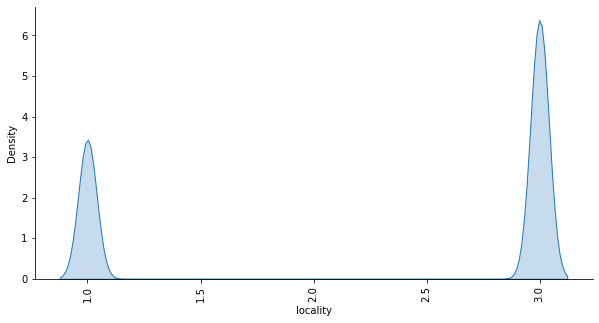

In [120]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(data['locality'].apply(lambda x : len(x.split(','))), shade=True)
plt.xticks(rotation=90)
plt.show()
del f,ax

## Bi-Variate Analysis

### Year Founded Vs Target

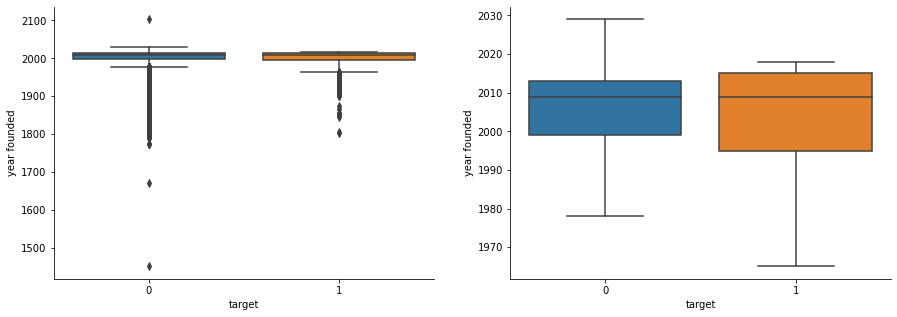

In [121]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
sns.despine(fig)
sns.boxplot(y='year founded',
            x='target',
            data=data[data['year founded'] != -999],
            showfliers=True,
            ax=axarr[0])
sns.boxplot(y='year founded',
            x='target',
            data=data[data['year founded'] != -999],
            showfliers=False,
            ax=axarr[1])
plt.close(2)
plt.close(3)
del fig, axarr

### Name Vs Target

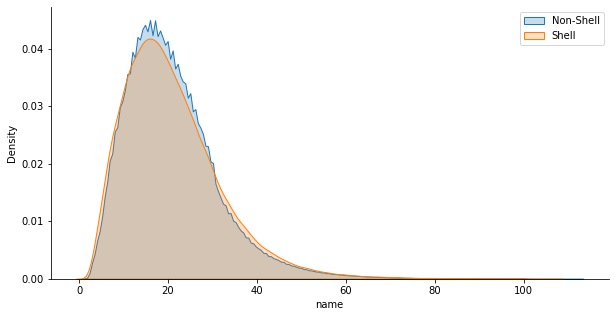

In [122]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(data[data.target == 0]['name'].apply(len), shade=True)
sns.kdeplot(data[data.target == 1]['name'].apply(len), shade=True)
plt.legend(['Non-Shell', 'Shell'])
plt.show()
del f, ax

### Domain Vs Target

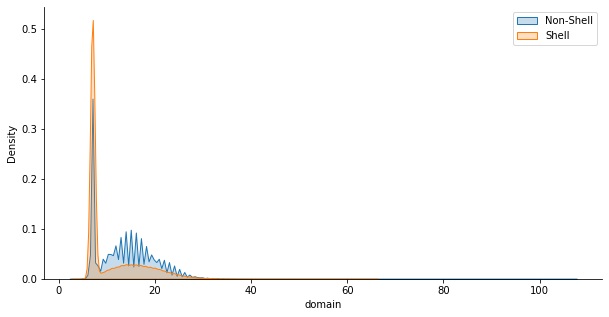

In [123]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(data[data.target == 0]['domain'].apply(len), shade=True)
sns.kdeplot(data[data.target == 1]['domain'].apply(len), shade=True)
plt.legend(['Non-Shell', 'Shell'])
plt.show()
del f, ax

### Locality Vs Target

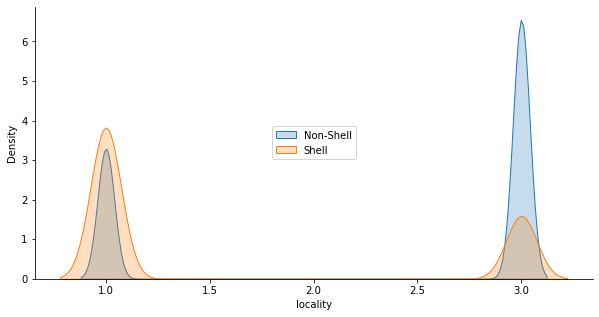

In [125]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(
    data[data.target == 0]['locality'].apply(lambda x: len(x.split(','))),
    shade=True)
sns.kdeplot(
    data[data.target == 1]['locality'].apply(lambda x: len(x.split(','))),
    shade=True)
plt.legend(['Non-Shell', 'Shell'],loc='center')
plt.show()
del f, ax

### url Vs Target

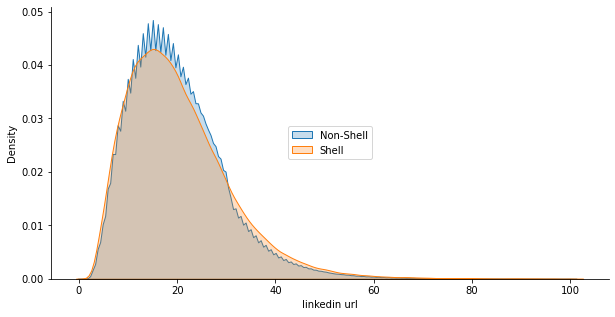

In [128]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(data[data.target == 0]['linkedin url'].apply(lambda x: len(x)),
            shade=True)
sns.kdeplot(data[data.target == 1]['linkedin url'].apply(lambda x: len(x)),
            shade=True)
plt.legend(['Non-Shell', 'Shell'], loc='center')
plt.show()
del f, ax

### country vs Target

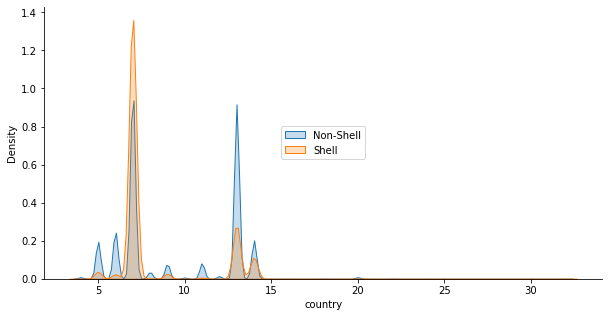

In [135]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(data[data.target == 0]['country'].apply(lambda x: len(x)),
            shade=True)
sns.kdeplot(data[data.target == 1]['country'].apply(lambda x: len(x)),
            shade=True)
plt.legend(['Non-Shell', 'Shell'], loc='center')
plt.show()
del f, ax

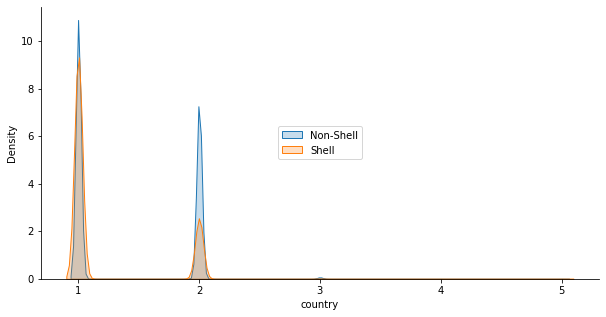

In [136]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(data[data.target == 0]['country'].apply(lambda x: len(x.split())),
            shade=True)
sns.kdeplot(data[data.target == 1]['country'].apply(lambda x: len(x.split())),
            shade=True)
plt.legend(['Non-Shell', 'Shell'], loc='center')
plt.show()
del f, ax

## Multi-Variate Analysis

### Current Vs Total Employees Vs Target

In [133]:
data['delta_emp'] = pd.Series(data['total employee estimate'] -
                              data['current employee estimate'])

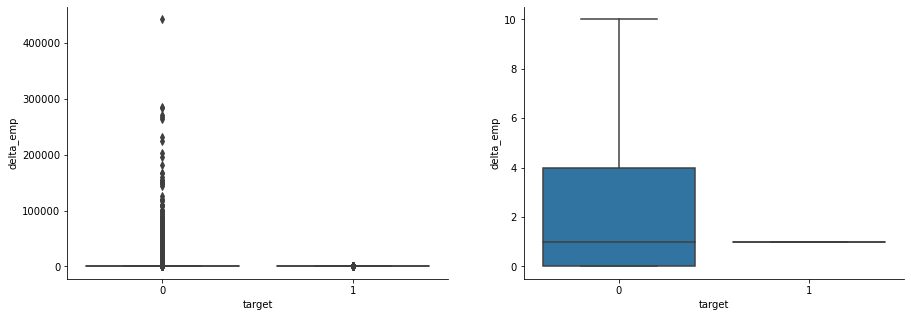

In [134]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
sns.despine(fig)
sns.boxplot(y='delta_emp', x='target', data=data, showfliers=True, ax=axarr[0])
sns.boxplot(y='delta_emp',
            x='target',
            data=data,
            showfliers=False,
            ax=axarr[1])
plt.close(2)
plt.close(3)
del fig, axarr

    - This very interesting plot as we can see shell companies has the delta between current employees and total employees very low
    - This is counterintuitive as you would not expect more people working in these companies 

# END